<a href="https://colab.research.google.com/github/cyuancheng/Stock_Prediction/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock price prediction using ARIMA and LSTM

In [52]:
!pip install pmdarima

In [0]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas_datareader.data import DataReader
from datetime import date

import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-ticks')
#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 6

import os
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

In [0]:
# set start and end date
start = date(2000, 1, 1)
end = date(2019,11,29)

Load stock data from yahoo finance

In [0]:
ticker = 'QQQ'
data_source = 'yahoo'
stock_data = DataReader(ticker, data_source, start, end)

In [56]:
display(stock_data.head(3))
display(stock_data.tail(3))

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,96.1875,90.7500,96.1875,94.75,36345200.0,83.116226
2000-01-04,93.5000,87.9375,92.0000,88.25,33786600.0,77.414307
2000-01-05,89.6250,84.2500,87.5000,86.00,42496600.0,75.440605


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-26,204.869995,204.050003,204.350006,204.610001,14780600.0,204.610001
2019-11-27,206.050003,204.889999,205.139999,206.039993,16963100.0,206.039993
2019-11-29,205.830002,205.000000,205.520004,205.100006,9854600.0,205.100006


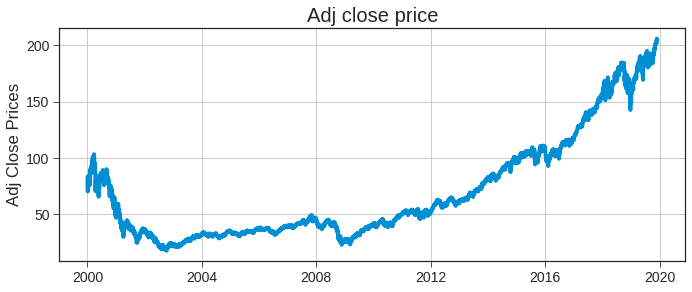

In [57]:
# show plot

#plot close price
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('')
plt.ylabel('Adj Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title('Adj close price')
plt.show()


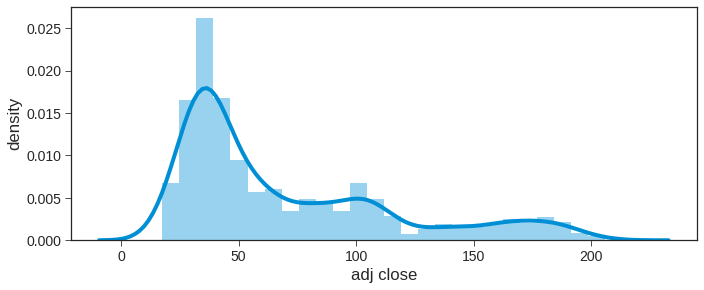

In [58]:
plt.figure(figsize=(10,4))
sns.distplot(stock_data['Adj Close'])
plt.xlabel('adj close')
plt.ylabel('density')
plt.show()

Check if the time series is stationary or not using Dickey Fuller test

In [0]:
#Test for staionarity
def test_stationarity(data):
    '''
    test the stationarity of time series
    using rolling average
    import: time series data (xy)
    '''
    #Determing rolling statistics
    rol_mean = data.rolling(12).mean()
    rol_std = data.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Average and Standard Deviation')
    plt.show(block=False)
    
    print("Result of Dickey Fuller test")
    adft = adfuller(data,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

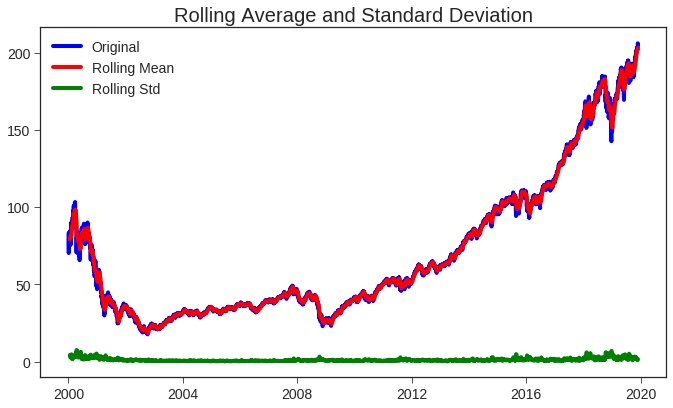

Result of Dickey Fuller test
Test Statistics                   2.244294
p-value                           0.998917
No. of lags used                 29.000000
Number of observations used    4980.000000
critical value (1%)              -3.431664
critical value (5%)              -2.862121
critical value (10%)             -2.567079
dtype: float64


In [60]:
test_stationarity(stock_data['Adj Close'])

Tests for trend non-stationarity using Dickey Fuller test
-- Null hypothesis is time series is non-stationary

p-value > 0.05, so the Null hypothesis can not be rejected. --> the time-series data is non-stationary.

In order to be able to analyze the stationary time-series data, we need to seperate seasonality and trend from the data.

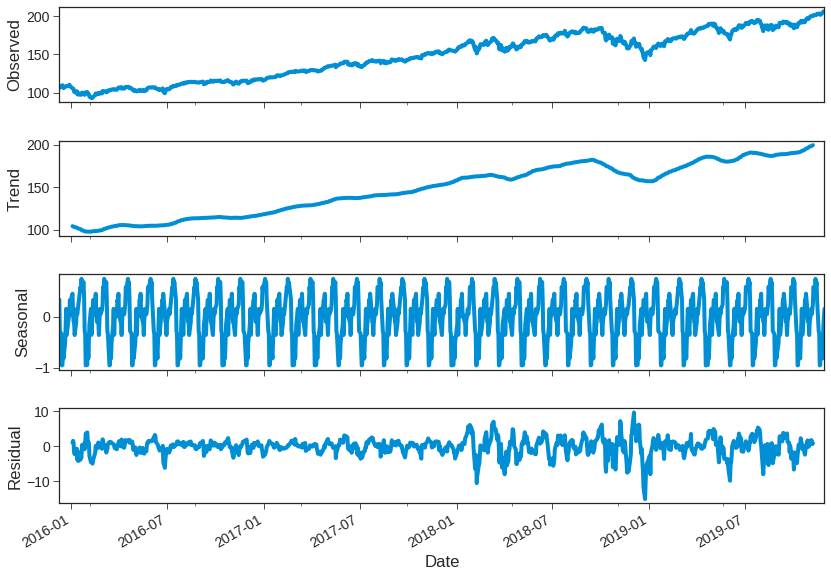

In [83]:
data_decompose = seasonal_decompose(stock_data['Adj Close'][-1000:], model='additive', freq = 30)

fig = data_decompose.plot()  
fig.set_size_inches(12, 9)

Make the stationary time-series data by taking the proportional change

No handles with labels found to put in legend.


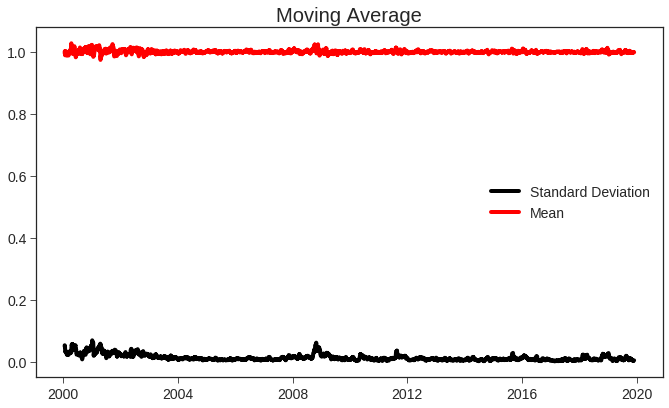

In [75]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_stationary = (stock_data['Adj Close'].shift(1)/stock_data['Adj Close']).dropna()
moving_avg = df_stationary .rolling(12).mean()
std_dev = df_stationary .rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

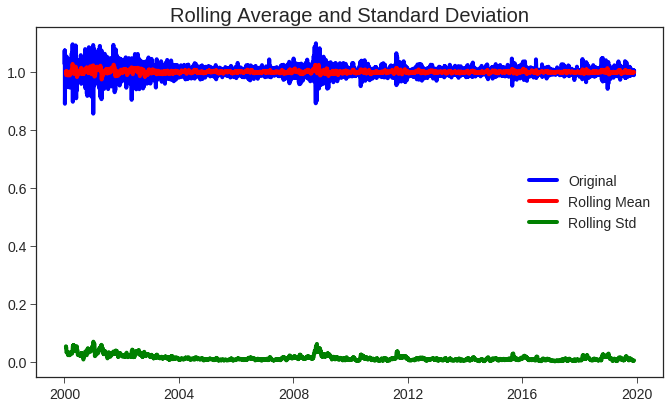

Result of Dickey Fuller test
Test Statistics               -1.256258e+01
p-value                        2.086859e-23
No. of lags used               2.500000e+01
Number of observations used    4.983000e+03
critical value (1%)           -3.431663e+00
critical value (5%)           -2.862120e+00
critical value (10%)          -2.567079e+00
dtype: float64


In [76]:
test_stationarity(df_stationary)#.diff().dropna()) .shift(1)/df

In [90]:
#len(stock_data['Adj Close'])*0.2
test_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-10,114.160004,112.809998,113.150002,113.400002,30154600.0,109.209244
2015-12-11,112.389999,110.720001,112.089996,110.790001,56022200.0,106.695671
2015-12-14,111.680000,109.379997,110.940002,111.629997,53098500.0,107.504662
2015-12-15,113.279999,112.169998,112.660004,112.309998,48428000.0,108.159531
2015-12-16,114.169998,111.889999,113.070000,113.980003,44944100.0,109.767807


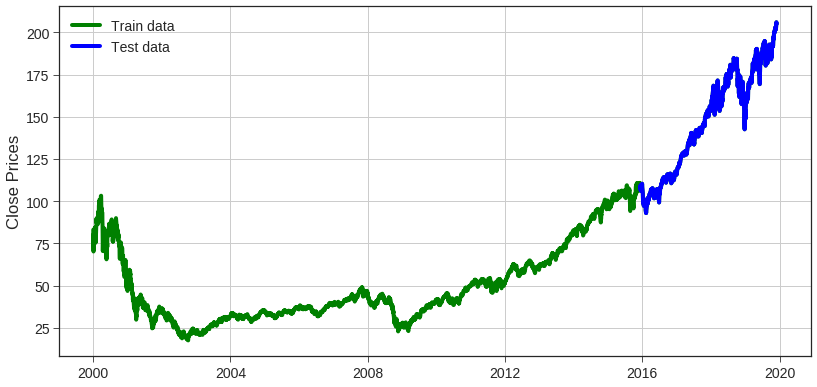

In [95]:
# train-test split
train_data, test_data = stock_data[0:-1000], stock_data[-1000:]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('')
plt.ylabel('Close Prices')
plt.plot(stock_data['Adj Close'], 'green', label='Train data')
plt.plot(test_data['Adj Close'], 'blue', label='Test data')
plt.legend()

#### Autoregressive (AR) model

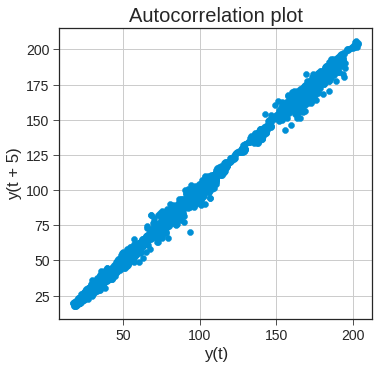

In [81]:
plt.figure(figsize=(5,5))
lag_plot(stock_data['Adj Close'], lag=5)
plt.title('Autocorrelation plot')
plt.grid(True)

In [102]:
# auto arima
model_autoARIMA = auto_arima(train_data['Adj Close'], 
                             start_p=0, 
                             start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, 
                             max_q=3, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             D=0, 
                             trend='c',
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True)
print(model_autoARIMA.summary())


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=11052.575, BIC=11065.168, Fit time=0.630 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=11050.430, BIC=11069.319, Fit time=0.249 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=11049.668, BIC=11068.557, Fit time=0.702 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=11052.575, BIC=11065.168, Fit time=0.585 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=11028.823, BIC=11054.008, Fit time=1.974 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=11025.450, BIC=11056.932, Fit time=2.195 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=11028.667, BIC=11053.852, Fit time=0.650 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=11028.562, BIC=11066.340, Fit time=3.264 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=11026.511, BIC=11064.289, Fit time=2.389 seconds
Fit ARIMA: order=(1

In [104]:
train_arima = train_data['Adj Close']
test_arima = test_data['Adj Close']

# Create a SARIMAX model
model = SARIMAX(train_arima, order=(3,1,3), seasonal_order=(0,0,0,0))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                 4010
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5496.232
Date:                Sat, 07 Dec 2019   AIC                          11006.463
Time:                        03:07:26   BIC                          11050.537
Sample:                             0   HQIC                         11022.084
                               - 4010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0816      0.046     -1.764      0.078      -0.172       0.009
ar.L2         -0.4324      0.035    -12.396      0.000      -0.501      -0.364
ar.L3          0.6781      0.044     15.455      0.0

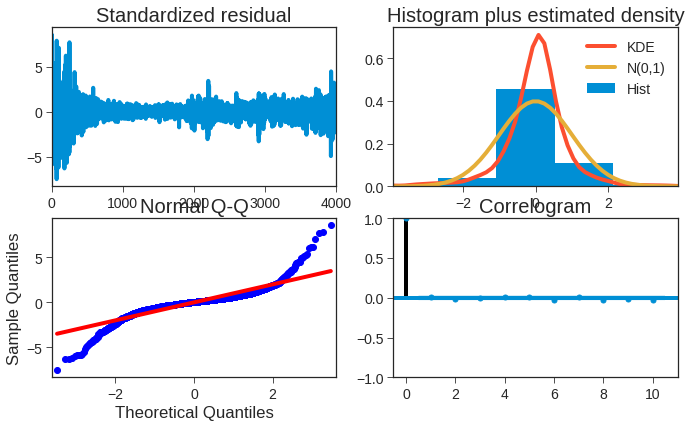

In [122]:
results.plot_diagnostics()
plt.show()

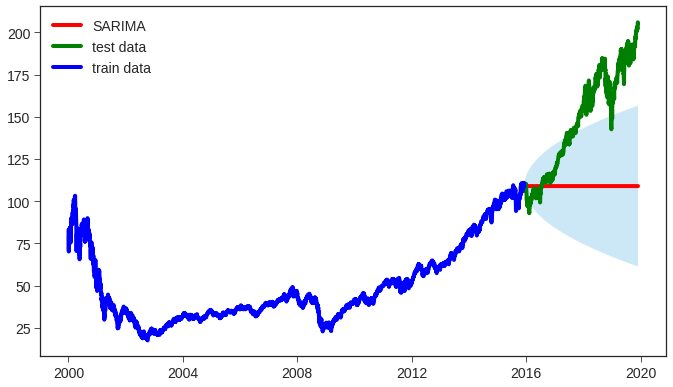

In [126]:
# Create SARIMA mean forecast
sarima_pred = results.get_forecast(steps=1000)
sarima_mean = sarima_pred.predicted_mean


# Extract the confidence intervals
conf_int = sarima_pred.conf_int()

# Extract the forecast dates
dates =sarima_mean.index

# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(test_data.index, sarima_mean, 'red', label='SARIMA')
plt.plot(test_data.index, test_data['Adj Close'], 'green', label='test data')
plt.plot(train_data.index, train_data['Adj Close'], 'blue', label='train data')

# Shade between the confidence intervals
plt.fill_between(test_data.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()

In [128]:
print('MSE: '+str(mean_squared_error(y, sarima_mean )))
print('MAE: '+str(mean_absolute_error(y, sarima_mean )))
print('RMSE: '+str(np.sqrt(mean_squared_error(y, sarima_mean ))))

MSE: 2455.488800840189
MAE: 40.72958410928045
RMSE: 49.55288892527043


#### LSTM

In [0]:
#train = train_data.iloc[:, 0:1].values # selecting open prices

train = train_data.drop(columns=['High', 'Low','Open','Close','Volume']).values
test = test_data.drop(columns=['High', 'Low','Open','Close','Volume']).values

# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # take 30 previous prices
    y_train.append(train_scaled[i, 0]) # 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
test_scaled = scaler.fit_transform(test) 
# Test dataset
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) # take 30 previous prices
    y_test.append(test_scaled[i, 0]) # 60-th price as y value
X_test, y_test = np.array(X_test), np.array(y_test)
# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [177]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint

# batch size and epochs
BATCH_SIZE = 64
EPOCHS = 40

# build LSTM prediction model
model = Sequential()
model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))
model.add(LSTM(units = 32))
model.add(Dropout(0.25))
# Adding the output layer
model.add(Dense(units = 1))
# Compile model
#model.compile(loss='mean_squared_error', 
#              optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6),
#              metrics=['accuracy'])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')#
# Model summary
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 64)             16896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
None


In [179]:
# Train model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test))

Train on 4003 samples, validate on 993 samples
Epoch 1/40
4003/4003 [==============================] - 5s 1ms/sample - loss: 0.0286 - val_loss: 0.0014
Epoch 2/40
4003/4003 [==============================] - 1s 302us/sample - loss: 0.0034 - val_loss: 0.0012
Epoch 3/40
4003/4003 [==============================] - 1s 329us/sample - loss: 0.0029 - val_loss: 7.9777e-04
Epoch 4/40
4003/4003 [==============================] - 1s 323us/sample - loss: 0.0025 - val_loss: 6.5666e-04
Epoch 5/40
4003/4003 [==============================] - 1s 362us/sample - loss: 0.0025 - val_loss: 9.5139e-04
Epoch 6/40
4003/4003 [==============================] - 1s 324us/sample - loss: 0.0024 - val_loss: 8.2507e-04
Epoch 7/40
4003/4003 [==============================] - 1s 328us/sample - loss: 0.0023 - val_loss: 6.1748e-04
Epoch 8/40
4003/4003 [==============================] - 1s 313us/sample - loss: 0.0021 - val_loss: 6.7414e-04
Epoch 9/40
4003/4003 [==============================] - 1s 318us/sample - loss: 0.0

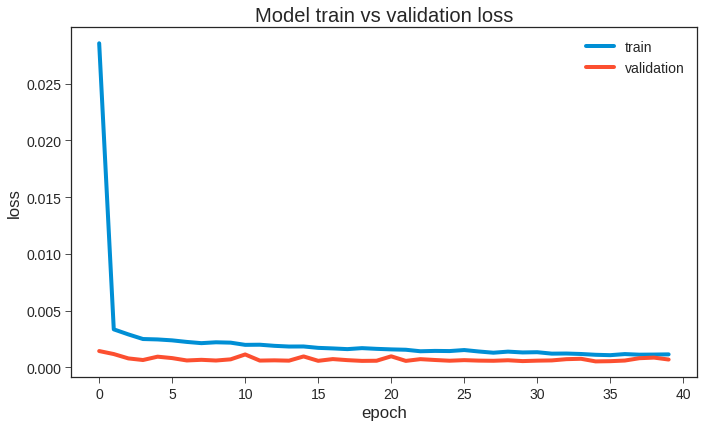

In [180]:
# plot the loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
combine = pd.concat((train_data['Adj Close'], test_data['Adj Close']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

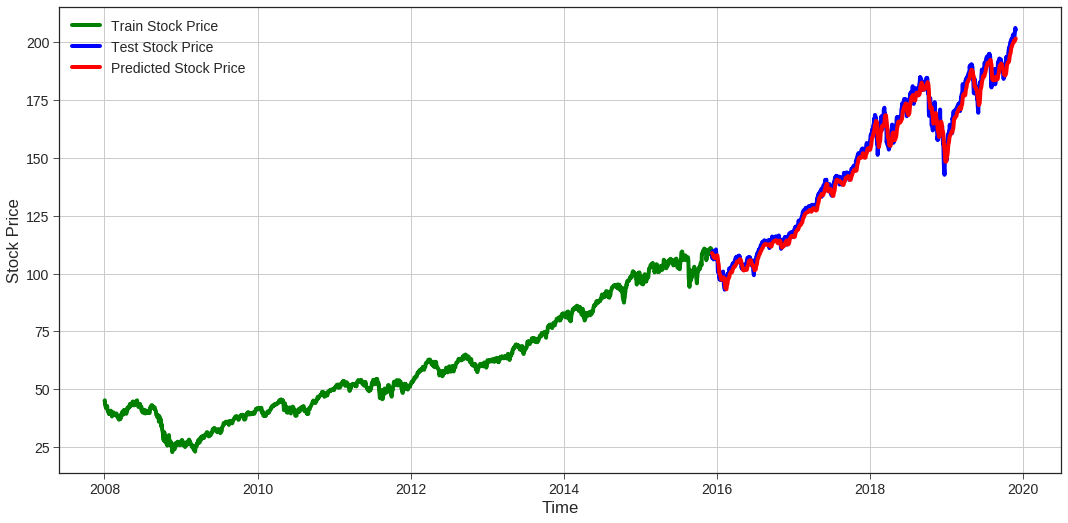

MSE: 8.868477456877706
MAE: 2.4482706146240236
RMSE: 2.9779989014231867


In [182]:
plt.figure(figsize=(16,8))
plt.plot(train_data.index[-2000:], train_data['Adj Close'].tail(2000), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['Adj Close'], color = 'blue', label = 'Test Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'red', label = 'Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(test_data['Adj Close'], predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Adj Close'], predicted_stock_price)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(test_data['Adj Close'], predicted_stock_price))
print('RMSE: '+str(rmse))